In [1]:
import cv2
import errno
import glob
from IPython.display import display
from ipywidgets import FloatProgress
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import time

# Prepare positive samples

As described [here](http://docs.opencv.org/2.4/doc/user_guide/ug_traincascade.html#positive-samples).

In [2]:
package_dirname = '/home/baxter/ros_ws/src/baxter_pick_and_place/'
base_dirname = os.path.join(package_dirname, 'data', 'sdd')
positive_dirname = os.path.join(base_dirname, 'positive')
print positive_dirname

/home/baxter/ros_ws/src/baxter_pick_and_place/data/sdd/positive


In [3]:
def silent_remove(filename):
    try:
        os.remove(filename)
    except OSError as e:
        if e.errno != errno.ENOENT:
            raise

In [4]:
def _extract_contour(img, c_low=50, c_high=270, a_low=100, a_high=200):
    """ Apply Canny edge detection to an image and return maximal 
    contour found.
    :param img: the image to work on
    :param c_low: lower Canny threshold
    :param c_high: upper Canny threshold
    :param a_low: lower bound for contour area
    :param a_high: upper bound for contour area
    :returns: the found contour, or None
    """
    canny = cv2.Canny(img, c_low, c_high, apertureSize=3)
    kernel = np.ones((3, 3), np.uint8)
    canny = cv2.morphologyEx(canny, cv2.MORPH_CLOSE, kernel, 
                             iterations=1)
    
    contours, _ = cv2.findContours(canny, cv2.RETR_LIST, 
                                   cv2.CHAIN_APPROX_SIMPLE)
    max_area = 0.0
    contour = None
    for c in contours:
        area = cv2.contourArea(c)
        if a_low < area < a_high:
            if area > max_area:
                max_area = area
                contour = c
    return contour

## bin

In [3]:
obj = 'bin'

In [4]:
positive_samples = glob.glob(os.path.join(positive_dirname, 
                                          '%s*' % obj, '*.jpg'))
positive_samples = [positive_samples[idx] 
                    for idx in range(len(positive_samples)) 
                    if 'roi' not in positive_samples[idx]]
print "Found %i positive samples." % len(positive_samples)

Found 210 positive samples.


### Show a sample object

(375, 620)


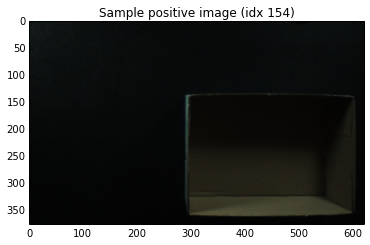

In [5]:
idx = np.random.randint(len(positive_samples))
sample = cv2.imread(positive_samples[idx])
print sample.shape[:2]
plt.imshow(cv2.cvtColor(sample, cv2.COLOR_BGR2RGB))
plt.title('Sample positive image (idx %i)' % idx)

### Segment object

In [5]:
def segment_area(img_name, th=200, c_low=50, c_high=270, 
                 ff_connectivity=4, a_low=100, a_high=200, 
                 verbose=True):
    """ Segment bin on an image using algorithms of increasing 
    complexity.
    :param img_name: path to the image to work on
    :param th: threshold for binary thresholding operation
    :param c_low: lower Canny threshold
    :param c_high: upper Canny threshold
    :param ff_connectivity: neighborhood relation (4, 8) to use for 
    flood fill operation
    :param a_low: lower bound for contour area
    :param a_high: upper bound for contour area
    :param verbose: whether to show plots or not
    :returns: a tuple (rroi, roi) containing the rotated roi and 
    corners and the upright roi enclosing the bin
    """
    img = cv2.imread(img_name)
    if img is None:
        raise Exception("Loading '%s' failed!" % img_name)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    equ = cv2.equalizeHist(gray)
    
    # try binary threshold
    _, thresh = cv2.threshold(equ, th, 255, cv2.THRESH_BINARY)
    contour = _extract_contour(thresh, c_low, c_high, a_low, a_high)
    if contour is not None:
        array = thresh
        title = 'threshold'
    else:  # try opening to remove small regions
        kernel = np.ones((2, 2), np.uint8)
        opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, 
                                   iterations=1)
        contour = _extract_contour(opening, c_low, c_high, 
                                   a_low, a_high)
        if contour is not None:
            array = opening
            title = 'opening'
        else:  # try outline of segmented regions
            kernel = np.ones((2, 2), np.uint8)
            closing = cv2.morphologyEx(opening, cv2.MORPH_OPEN, 
                                       kernel, iterations=1)
            outline = cv2.morphologyEx(closing, cv2.MORPH_GRADIENT, 
                                       kernel, iterations=2)
            contour = _extract_contour(outline, c_low, c_high, 
                                       a_low, a_high)
            if contour is not None:
                array = outline
                title = 'outline'
            else:  # see if flood-filling the image helps
                h, w = outline.shape[:2]
                mask = np.zeros((h+2, w+2), np.uint8)
                mask[1:-1, 1:-1] = outline
                seed_pt = (mask.shape[0], 0)
                flooded = gray.copy()
                flags = ff_connectivity | cv2.FLOODFILL_FIXED_RANGE
                cv2.floodFill(flooded, mask, seed_pt, (255, 255, 255), 
                              (50,)*3, (255,)*3, flags)
                contour = _extract_contour(flooded, c_low, c_high, 
                                           a_low, a_high)
                if contour is not None:
                    array = flooded
                    title = 'flooded'
    if contour is None:
        raise ValueError('No contour found!')
    
    plt.figure(figsize=(11, 20))
    plt.subplot(121)
    plt.imshow(array, cmap='gray')
    plt.title(title)
    sample = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if not contour is None:
        rrect = cv2.minAreaRect(contour)
        box = cv2.cv.BoxPoints(rrect)
        b = np.int0(box)
        cv2.drawContours(sample, [b], 0, (0, 255, 0), 2)
        cv2.circle(sample, (int(rrect[0][0]), int(rrect[0][1])), 4, 
                   (0, 255, 0), 2)
    
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(sample, (x, y), (x+w, y+h), (255, 0, 0), 2)
        cv2.circle(sample, (x+w/2, y+h/2), 3, (255, 0, 0), 2)
    plt.subplot(122); plt.imshow(sample)
    plt.savefig(os.path.splitext(img_name)[0] + '_roi.jpg', 
                bbox_inches='tight')
    if not verbose:
        plt.close()
    
    return (rrect, box), (x, y, w, h)

In [17]:
positive_filename = os.path.join(base_dirname, '%s_info.dat' % obj)
silent_remove(positive_filename)
failed_filename = os.path.join(base_dirname, '%s_info_fail.dat' % obj)
silent_remove(failed_filename)

th = 210
c_low = 110
c_high = 170
a_low = 10000
a_high = 100000

n_pos = 0
n_fail = 0
f = FloatProgress(min=0, max=len(positive_samples))
f.description = "Processing base '%s'-images" % obj
display(f)
start = time.time()
for ps in positive_samples:
    try:
        _, roi = segment_area(ps, th=th, c_low=c_low, c_high=c_high, 
                              ff_connectivity=4, 
                              a_low=a_low, a_high=a_high, 
                              verbose=False)
        with open(positive_filename, 'a') as fp:
            fp.write('%s  %i  %i %i %i %i\n' % 
                     (ps.split(base_dirname)[-1], 1, 
                      roi[0], roi[1], roi[2], roi[3]))
        n_pos += 1
    except ValueError:
        with open(failed_filename, 'a') as fp:
            fp.write('%s\n' % ps)
        n_fail += 1
    f.value = n_pos+n_fail
    
print "Wrote %i positive '%s'-samples in %.2fs to %s." % \
    (n_pos, obj, time.time()-start, positive_filename)
print "(%i/%i samples failed.)" % (n_fail, len(positive_samples))

Wrote 207 positive 'bin'-samples in 175.21s to /home/baxter/ros_ws/src/baxter_pick_and_place/data/sdd/bin_info.dat.
(3/210 samples failed.)


In [11]:
with open(failed_filename, 'r') as fp:
    failed_samples = fp.read().splitlines()

for fs in failed_samples:
    print fs

/home/baxter/ros_ws/src/baxter_pick_and_place/data/sdd/positive/bin+all/384553221228.jpg
/home/baxter/ros_ws/src/baxter_pick_and_place/data/sdd/positive/bin+all/395993370399.jpg
/home/baxter/ros_ws/src/baxter_pick_and_place/data/sdd/positive/bin+all/143084700714.jpg


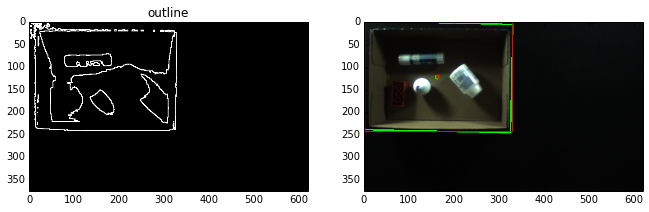

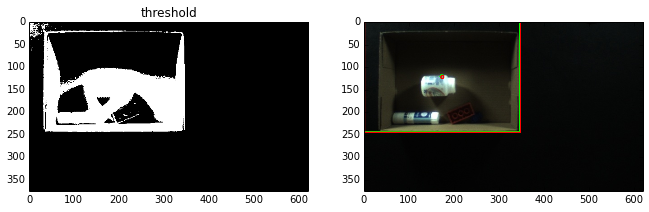

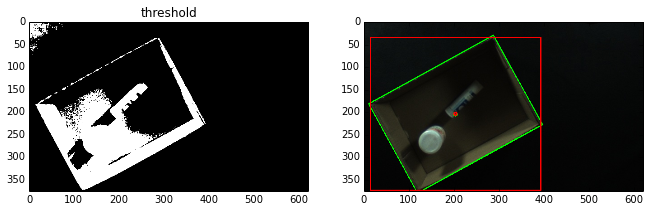

In [20]:
th = 215
c_low = 110
c_high = 170
a_low = 10000
a_high = 100000

for fs in failed_samples:
    _, roi = segment_area(fs, th=th, c_low=c_low, c_high=c_high, 
                          ff_connectivity=4, 
                          a_low=a_low, a_high=a_high,  verbose=True)
    with open(positive_filename, 'a') as fp:
            fp.write('%s  %i  %i %i %i %i\n' % 
                     (fs.split(base_dirname)[-1], 1, 
                      roi[0], roi[1], roi[2], roi[3]))

In [12]:
!rm {failed_filename}

## duplo_brick

In [6]:
obj = 'duplo_brick'

In [35]:
positive_samples = glob.glob(os.path.join(positive_dirname, 
                                          '%s' % obj, '*.jpg'))
positive_samples = [positive_samples[idx] 
                    for idx in range(len(positive_samples)) 
                    if 'roi' not in positive_samples[idx]]
print "Found %i positive samples." % len(positive_samples)

Found 25 positive samples.


### Show a sample object

(375, 620)


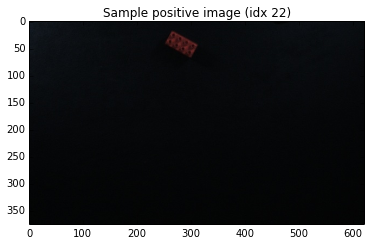

In [8]:
idx = np.random.randint(len(positive_samples))
sample = cv2.imread(positive_samples[idx])
print sample.shape[:2]
plt.imshow(cv2.cvtColor(sample, cv2.COLOR_BGR2RGB))
plt.title('Sample positive image (idx %i)' % idx)

### Segment object

In [41]:
def segment_red_area(img_name, th=200, c_low=50, c_high=270, 
                     a_low=100, a_high=200, verbose=True):
    img = cv2.imread(img_name)
    if img is None:
        raise Exception("Loading '%s' failed!" % img_name)
    
    # look only at red channel
    red = cv2.split(img)[2]
    _, thresh = cv2.threshold(red, th, 255, cv2.THRESH_BINARY)
    contour = _extract_contour(thresh, c_low, c_high, a_low, a_high)
    if contour is None:
        raise ValueError('No contour found!')
    
    plt.figure(figsize=(11, 20))
    plt.subplot(131)
    plt.imshow(red, cmap='gray')
    plt.subplot(132)
    plt.imshow(thresh, cmap='gray')
    sample = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if not contour is None:
        rrect = cv2.minAreaRect(contour)
        box = cv2.cv.BoxPoints(rrect)
        b = np.int0(box)
        cv2.drawContours(sample, [b], 0, (0, 255, 0), 2)
        cv2.circle(sample, (int(rrect[0][0]), int(rrect[0][1])), 4, 
                   (0, 255, 0), 2)
    
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(sample, (x, y), (x+w, y+h), (255, 0, 0), 2)
        cv2.circle(sample, (x+w/2, y+h/2), 3, (255, 0, 0), 2)
    plt.subplot(133)
    plt.imshow(sample)
    plt.savefig(os.path.splitext(img_name)[0] + '_roi.jpg', 
                bbox_inches='tight')
    if not verbose:
        plt.close()
    
    return (rrect, box), (x, y, w, h)

In [46]:
positive_filename = os.path.join(base_dirname, '%s_info.dat' % obj)
silent_remove(positive_filename)
failed_filename = os.path.join(base_dirname, '%s_info_fail.dat' % obj)
silent_remove(failed_filename)

th = 25
c_low = 100
c_high = 170
a_low = 50
a_high = 2100

n_pos = 0
n_fail = 0
f = FloatProgress(min=0, max=len(positive_samples))
f.description = "Processing base '%s'-images" % obj
display(f)
start = time.time()
for ps in positive_samples:
    try:
        _, roi = segment_red_area(ps, th=th, 
                                  c_low=c_low, c_high=c_high, 
                                  a_low=a_low, a_high=a_high, 
                                  verbose=False)
        with open(positive_filename, 'a') as fp:
            fp.write('%s  %i  %i %i %i %i\n' % 
                     (ps.split(base_dirname)[-1], 1, 
                      roi[0], roi[1], roi[2], roi[3]))
        n_pos += 1
    except ValueError:
        with open(failed_filename, 'a') as fp:
            fp.write('%s\n' % ps)
        n_fail += 1
    f.value = n_pos+n_fail
    
print "Wrote %i positive '%s'-samples in %.2fs to %s." % \
    (n_pos, obj, time.time()-start, positive_filename)
print "(%i/%i samples failed.)" % (n_fail, len(positive_samples))

Wrote 25 positive 'duplo_brick'-samples in 14.95s to /home/baxter/ros_ws/src/baxter_pick_and_place/data/sdd/duplo_brick_info.dat.
(0/25 samples failed.)


## extra_mints

In [85]:
obj = 'extra_mints'

In [86]:
positive_samples = glob.glob(os.path.join(positive_dirname, 
                                          '%s' % obj, '*.jpg'))
positive_samples = [positive_samples[idx] 
                    for idx in range(len(positive_samples)) 
                    if 'roi' not in positive_samples[idx]]
print "Found %i positive samples." % len(positive_samples)

Found 25 positive samples.


### Show a sample object

(375, 620)


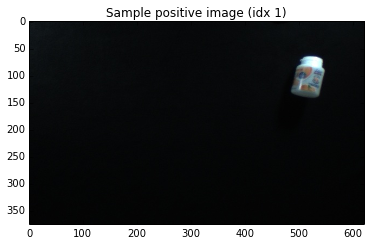

In [87]:
idx = np.random.randint(len(positive_samples))
sample = cv2.imread(positive_samples[idx])
print sample.shape[:2]
plt.imshow(cv2.cvtColor(sample, cv2.COLOR_BGR2RGB))
plt.title('Sample positive image (idx %i)' % idx)

### Segment object

In [103]:
positive_filename = os.path.join(base_dirname, '%s_info.dat' % obj)
silent_remove(positive_filename)
failed_filename = os.path.join(base_dirname, '%s_info_fail.dat' % obj)
silent_remove(failed_filename)

th = 251
c_low = 110
c_high = 170
a_low = 1700
a_high = 3000

n_pos = 0
n_fail = 0
f = FloatProgress(min=0, max=len(positive_samples))
f.description = "Processing base '%s'-images" % obj
display(f)
start = time.time()
for ps in positive_samples:
    try:
        _, roi = segment_area(ps, th=th, c_low=c_low, c_high=c_high, 
                              ff_connectivity=4, 
                              a_low=a_low, a_high=a_high, 
                              verbose=False)
        with open(positive_filename, 'a') as fp:
            fp.write('%s  %i  %i %i %i %i\n' % 
                     (ps.split(base_dirname)[-1], 1, 
                      roi[0], roi[1], roi[2], roi[3]))
        n_pos += 1
    except ValueError:
        with open(failed_filename, 'a') as fp:
            fp.write('%s\n' % ps)
        n_fail += 1
    f.value = n_pos+n_fail
    
print "Wrote %i positive '%s'-samples in %.2fs to %s." % \
    (n_pos, obj, time.time()-start, positive_filename)
print "(%i/%i samples failed.)" % (n_fail, len(positive_samples))

Wrote 24 positive 'extra_mints'-samples in 10.50s to /home/baxter/ros_ws/src/baxter_pick_and_place/data/sdd/extra_mints_info.dat.
(1/25 samples failed.)


In [104]:
with open(failed_filename, 'r') as fp:
    failed_samples = fp.read().splitlines()

for fs in failed_samples:
    print fs

/home/baxter/ros_ws/src/baxter_pick_and_place/data/sdd/positive/extra_mints/881606655599.jpg


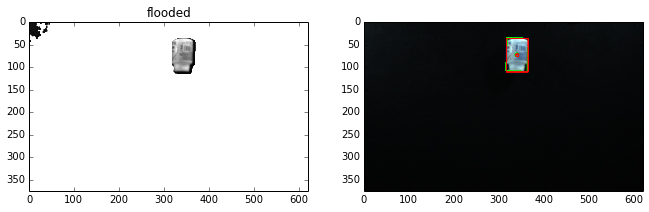

In [106]:
th = 250
c_low = 110
c_high = 170

for fs in failed_samples:
    _, roi = segment_area(fs, th=th, c_low=c_low, c_high=c_high, 
                          ff_connectivity=4, 
                          a_low=1700, a_high=3000,  verbose=True)
    with open(positive_filename, 'a') as fp:
            fp.write('%s  %i  %i %i %i %i\n' % 
                     (fs.split(base_dirname)[-1], 1, 
                      roi[0], roi[1], roi[2], roi[3]))

In [107]:
!rm {failed_filename}

## glue_stick

In [58]:
obj = 'glue_stick'

In [59]:
positive_samples = glob.glob(os.path.join(positive_dirname, 
                                          '%s' % obj, '*.jpg'))
positive_samples = [positive_samples[idx] 
                    for idx in range(len(positive_samples)) 
                    if 'roi' not in positive_samples[idx]]
print "Found %i positive samples." % len(positive_samples)

Found 25 positive samples.


### Show a sample object

(375, 620)


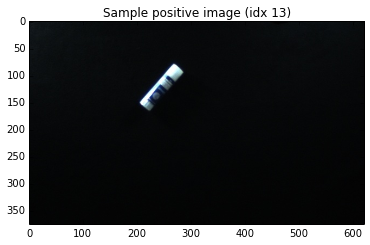

In [60]:
idx = np.random.randint(len(positive_samples))
sample = cv2.imread(positive_samples[idx])
print sample.shape[:2]
plt.imshow(cv2.cvtColor(sample, cv2.COLOR_BGR2RGB))
plt.title('Sample positive image (idx %i)' % idx)

### Segment object

In [84]:
positive_filename = os.path.join(base_dirname, '%s_info.dat' % obj)
silent_remove(positive_filename)
failed_filename = os.path.join(base_dirname, '%s_info_fail.dat' % obj)
silent_remove(failed_filename)

th = 252
c_low = 100
c_high = 170
a_low = 1300
a_high = 3100

n_pos = 0
n_fail = 0
f = FloatProgress(min=0, max=len(positive_samples))
f.description = "Processing base '%s'-images" % obj
display(f)
start = time.time()
for ps in positive_samples:
    try:
        _, roi = segment_area(ps, th=th, c_low=c_low, c_high=c_high, 
                              ff_connectivity=4, 
                              a_low=a_low, a_high=a_high, 
                              verbose=False)
        with open(positive_filename, 'a') as fp:
            fp.write('%s  %i  %i %i %i %i\n' % 
                     (ps.split(base_dirname)[-1], 1, 
                      roi[0], roi[1], roi[2], roi[3]))
        n_pos += 1
    except ValueError:
        with open(failed_filename, 'a') as fp:
            fp.write('%s\n' % ps)
        n_fail += 1
    f.value = n_pos+n_fail
    
print "Wrote %i positive '%s'-samples in %.2fs to %s." % \
    (n_pos, obj, time.time()-start, positive_filename)
print "(%i/%i samples failed.)" % (n_fail, len(positive_samples))

Wrote 25 positive 'glue_stick'-samples in 10.73s to /home/baxter/ros_ws/src/baxter_pick_and_place/data/sdd/glue_stick_info.dat.
(0/25 samples failed.)


## golf_ball

In [108]:
obj = 'golf_ball'

In [109]:
positive_samples = glob.glob(os.path.join(positive_dirname, 
                                          '%s' % obj, '*.jpg'))
positive_samples = [positive_samples[idx] 
                    for idx in range(len(positive_samples)) 
                    if 'roi' not in positive_samples[idx]]
print "Found %i positive samples." % len(positive_samples)

Found 25 positive samples.


### Show a sample object

(375, 620)


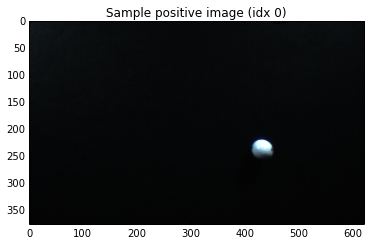

In [110]:
idx = np.random.randint(len(positive_samples))
sample = cv2.imread(positive_samples[idx])
print sample.shape[:2]
plt.imshow(cv2.cvtColor(sample, cv2.COLOR_BGR2RGB))
plt.title('Sample positive image (idx %i)' % idx)

### Segment object

In [135]:
def segment_circle(img_name, th=200, c_low=50, c_high=270, 
                   ff_connectivity=4, a_low=100, a_high=200, 
                   verbose=True):
    """ Segment bin on an image using algorithms of increasing 
    complexity.
    :param img_name: path to the image to work on
    :param th: threshold for binary thresholding operation
    :param c_low: lower Canny threshold
    :param c_high: upper Canny threshold
    :param ff_connectivity: neighborhood relation (4, 8) to use for 
    flood fill operation
    :param a_low: lower bound for contour area
    :param a_high: upper bound for contour area
    :param verbose: whether to show plots or not
    :returns: a tuple (rroi, roi) containing the rotated roi and 
    corners and the upright roi enclosing the bin
    """
    img = cv2.imread(img_name)
    if img is None:
        raise Exception("Loading '%s' failed!" % img_name)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    equ = cv2.equalizeHist(gray)
    
    # try binary threshold
    _, thresh = cv2.threshold(equ, th, 255, cv2.THRESH_BINARY)
    contour = _extract_contour(thresh, c_low, c_high, a_low, a_high)
    if contour is not None:
        array = thresh
        title = 'threshold'
    else:  # try opening to remove small regions
        kernel = np.ones((2, 2), np.uint8)
        opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, 
                                   iterations=1)
        contour = _extract_contour(opening, c_low, c_high, 
                                   a_low, a_high)
        if contour is not None:
            array = opening
            title = 'opening'
        else:  # try outline of segmented regions
            kernel = np.ones((2, 2), np.uint8)
            closing = cv2.morphologyEx(opening, cv2.MORPH_OPEN, 
                                       kernel, iterations=1)
            outline = cv2.morphologyEx(closing, cv2.MORPH_GRADIENT, 
                                       kernel, iterations=2)
            contour = _extract_contour(outline, c_low, c_high, 
                                       a_low, a_high)
            if contour is not None:
                array = outline
                title = 'outline'
            else:  # see if flood-filling the image helps
                h, w = outline.shape[:2]
                mask = np.zeros((h+2, w+2), np.uint8)
                mask[1:-1, 1:-1] = outline
                seed_pt = (mask.shape[0], 0)
                flooded = gray.copy()
                flags = ff_connectivity | cv2.FLOODFILL_FIXED_RANGE
                cv2.floodFill(flooded, mask, seed_pt, (255, 255, 255), 
                              (50,)*3, (255,)*3, flags)
                contour = _extract_contour(flooded, c_low, c_high, 
                                           a_low, a_high)
                if contour is not None:
                    array = flooded
                    title = 'flooded'
    if contour is None:
        raise ValueError('No contour found!')
    
    plt.figure(figsize=(11, 20))
    plt.subplot(121)
    plt.imshow(array, cmap='gray')
    plt.title(title)
    sample = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if not contour is None:
        offset = 8
        x, y, w, h = cv2.boundingRect(contour)
        x -= offset
        y -= offset/2
        w += 2*offset
        h += 2*offset
        cv2.rectangle(sample, (x, y), (x+w, y+h), (255, 0, 0), 2)
        cv2.circle(sample, (x+w/2, y+h/2), 3, (255, 0, 0), 2)
    plt.subplot(122); plt.imshow(sample)
    plt.savefig(os.path.splitext(img_name)[0] + '_roi.jpg', 
                bbox_inches='tight')
    if not verbose:
        plt.close()
    
    return x, y, w, h

In [137]:
positive_filename = os.path.join(base_dirname, '%s_info.dat' % obj)
silent_remove(positive_filename)
failed_filename = os.path.join(base_dirname, '%s_info_fail.dat' % obj)
silent_remove(failed_filename)

th = 254
c_low = 100
c_high = 170
a_low = 400
a_high = 900

n_pos = 0
n_fail = 0
f = FloatProgress(min=0, max=len(positive_samples))
f.description = "Processing base '%s'-images" % obj
display(f)
start = time.time()
for ps in positive_samples:
    try:
        roi = segment_circle(ps, th=th, c_low=c_low, c_high=c_high, 
                             ff_connectivity=4, 
                             a_low=a_low, a_high=a_high, 
                             verbose=False)
        with open(positive_filename, 'a') as fp:
            fp.write('%s  %i  %i %i %i %i\n' % 
                     (ps.split(base_dirname)[-1], 1, 
                      roi[0], roi[1], roi[2], roi[3]))
        n_pos += 1
    except ValueError:
        with open(failed_filename, 'a') as fp:
            fp.write('%s\n' % ps)
        n_fail += 1
    f.value = n_pos+n_fail
    
print "Wrote %i positive '%s'-samples in %.2fs to %s." % \
    (n_pos, obj, time.time()-start, positive_filename)
print "(%i/%i samples failed.)" % (n_fail, len(positive_samples))

Wrote 25 positive 'golf_ball'-samples in 10.93s to /home/baxter/ros_ws/src/baxter_pick_and_place/data/sdd/golf_ball_info.dat.
(0/25 samples failed.)


## robot

In [138]:
obj = 'robot'

In [139]:
positive_samples = glob.glob(os.path.join(positive_dirname, 
                                          '%s' % obj, '*.jpg'))
positive_samples = [positive_samples[idx] 
                    for idx in range(len(positive_samples)) 
                    if 'roi' not in positive_samples[idx]]
print "Found %i positive samples." % len(positive_samples)

Found 25 positive samples.


### Show a sample object

(375, 620)


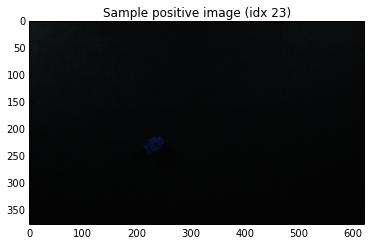

In [140]:
idx = np.random.randint(len(positive_samples))
sample = cv2.imread(positive_samples[idx])
print sample.shape[:2]
plt.imshow(cv2.cvtColor(sample, cv2.COLOR_BGR2RGB))
plt.title('Sample positive image (idx %i)' % idx)

### Segment object

In [141]:
def segment_blue_area(img_name, th=200, c_low=50, c_high=270, 
                      a_low=100, a_high=200, verbose=True):
    img = cv2.imread(img_name)
    if img is None:
        raise Exception("Loading '%s' failed!" % img_name)
    
    # look only at red channel
    blue = cv2.split(img)[0]
    _, thresh = cv2.threshold(blue, th, 255, cv2.THRESH_BINARY)
    contour = _extract_contour(thresh, c_low, c_high, a_low, a_high)
    if contour is None:
        raise ValueError('No contour found!')
    
    plt.figure(figsize=(11, 20))
    plt.subplot(131)
    plt.imshow(blue, cmap='gray')
    plt.subplot(132)
    plt.imshow(thresh, cmap='gray')
    sample = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if not contour is None:
        rrect = cv2.minAreaRect(contour)
        box = cv2.cv.BoxPoints(rrect)
        b = np.int0(box)
        cv2.drawContours(sample, [b], 0, (0, 255, 0), 2)
        cv2.circle(sample, (int(rrect[0][0]), int(rrect[0][1])), 4, 
                   (0, 255, 0), 2)
    
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(sample, (x, y), (x+w, y+h), (255, 0, 0), 2)
        cv2.circle(sample, (x+w/2, y+h/2), 3, (255, 0, 0), 2)
    plt.subplot(133)
    plt.imshow(sample)
    plt.savefig(os.path.splitext(img_name)[0] + '_roi.jpg', 
                bbox_inches='tight')
    if not verbose:
        plt.close()
    
    return (rrect, box), (x, y, w, h)

In [148]:
positive_filename = os.path.join(base_dirname, '%s_info.dat' % obj)
silent_remove(positive_filename)
failed_filename = os.path.join(base_dirname, '%s_info_fail.dat' % obj)
silent_remove(failed_filename)

th = 26
c_low = 100
c_high = 170
a_low = 400
a_high = 1900

n_pos = 0
n_fail = 0
f = FloatProgress(min=0, max=len(positive_samples))
f.description = "Processing base '%s'-images" % obj
display(f)
start = time.time()
for ps in positive_samples:
    try:
        _, roi = segment_blue_area(ps, th=th, 
                                   c_low=c_low, c_high=c_high, 
                                   a_low=a_low, a_high=a_high, 
                                   verbose=False)
        with open(positive_filename, 'a') as fp:
            fp.write('%s  %i  %i %i %i %i\n' % 
                     (ps.split(base_dirname)[-1], 1, 
                      roi[0], roi[1], roi[2], roi[3]))
        n_pos += 1
    except ValueError:
        with open(failed_filename, 'a') as fp:
            fp.write('%s\n' % ps)
        n_fail += 1
    f.value = n_pos+n_fail
    
print "Wrote %i positive '%s'-samples in %.2fs to %s." % \
    (n_pos, obj, time.time()-start, positive_filename)
print "(%i/%i samples failed.)" % (n_fail, len(positive_samples))

Wrote 25 positive 'robot'-samples in 15.19s to /home/baxter/ros_ws/src/baxter_pick_and_place/data/sdd/robot_info.dat.
(0/25 samples failed.)
